### Neural Network Hyperparameter Tuning

This turorial is based on https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import tensorflow
import tensorflow.keras as keras

You may need to install keras_tuner.

In [5]:
#%pip install keras_tuner

In [6]:
import keras_tuner as kt

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

## feature scaling 
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

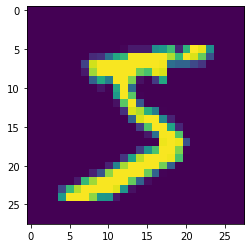

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

In [9]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### We define a function "model builder".

In [12]:
def model_builder(hp):
    model = keras.Sequential() ## start model
    model.add(keras.layers.Flatten(input_shape=(28, 28))) ## first layer, input size 28 by 28 & flatten it

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32) ## number of neurons b/t 32 and 512 using increments of 32
    model.add(keras.layers.Dense(units=hp_units, activation='relu')) ## next(2nd) layer, dense/hidden layer. optimize # of neurons, hp_units b/t 35 & 512
    model.add(keras.layers.Dense(10, activation='softmax')) ## 3rd layer, output layer, w/ 10 neurons b/c 10 diff numbers

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']) ## looking at accuracy

    return model

### The Keras Tuner has three tuners available - RandomSearch, Hyperband, Bayesian Optimization (https://keras.io/guides/keras_tuner/getting_started/). In this example, we will use the Hyperband tuner (https://arxiv.org/pdf/1603.06560.pdf).

The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. 

In [13]:
## hyperband - improved version of random search

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10, ## train only up to 10 to save time
                     seed=0, ## need seed number, like random state 
                     hyperband_iterations=4, ## how many times iterate, default is 1
                     project_name='hptest') ## name - if you run a new hyperparam you change the name

# Use a differnt project_name if you'd like to run a new hyperparameter tuning.

### We can print out the summary of the search space.

In [14]:
tuner.search_space_summary() ## only thing varyig # of neurons so you see min value 32 etc.

Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


### Let's search the hyperparameter space.

In [15]:
tuner.search(X_train, y_train, validation_split=0.2) ## search hyperparam space 

Trial 21 Complete [00h 00m 17s]
val_accuracy: 0.9762499928474426

Best val_accuracy So Far: 0.9769999980926514
Total elapsed time: 00h 03m 31s
INFO:tensorflow:Oracle triggered exit


### Let's print out the optimal hyperparameters.

In [17]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448.



### Build a model with the optimal hyperparameters.

In [18]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 448)               351680    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                4490      
Total params: 356,170
Trainable params: 356,170
Non-trainable params: 0
_________________________________________________________________


### TODO: Now, let's train the model with the optimal hyperparameters. You may want to implement early stopping.

In [ ]:
stop_early = keras.callbacks.EarlyStopping(moniter='val_loss',paitence=10)


### TODO: Evaluate your model. What accuracy did you get on the test dataset?

In [ ]:
loss, accuracy = model.evaluate()


### TODO: Make a plot showing loss, validation loss vs. # of epochs.

### TODO: Make a plot showing accuracy, validation accuracy vs. # of epochs.

### What if we'd like to optimize more than one hyperparameters at the same time?

In [19]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    ## if you want to optimize learning rate
   # hp_learning_rate = hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1]) ## vary b/t these 4 values 
   # model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), ## use optimizer adam 
   #             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
   #             metrics=['accuracy'])
    
    ## changing the optimizer, so we want to change the optimizer and learning rate
    adam = keras.optimizers.Adam(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1])) ## choose adam, inside adam change learning rate
    rmsprop = keras.optimizers.RMSprop(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1])) ## same^ 
    sgd = keras.optimizers.SGD(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1]))
   
    choiceval = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']) ## now choose b/t the three above
    
    if choiceval == 'adam': ## if adam is chosen, use optimizer adam
        optim = adam
    elif choiceval == 'rmsprop': ## same ^
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(optimizer=optim,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

## cant use this to decide the # of layers, have to decide this on our own

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     seed=0,
                     hyperband_iterations=1,
                     project_name='hptest2')

/apps/tensorflow/2.6.0/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
tuner.search_space_summary()
## units # of neurons in hidden layer, then learning rate and optimizer 

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}


In [22]:
tuner.search(X_train, y_train, validation_split=0.2)

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.9639166593551636

Best val_accuracy So Far: 0.9793333411216736
Total elapsed time: 00h 07m 33s
INFO:tensorflow:Oracle triggered exit


In [23]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer {best_hps.get('optimizer')}
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer sgd
is 0.1.



In [24]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               301440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3850      
Total params: 305,290
Trainable params: 305,290
Non-trainable params: 0
_________________________________________________________________


In [25]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Epoch 1/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3102 - accuracy: 0.9130 - val_loss: 0.1720 - val_accuracy: 0.9514
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1462 - accuracy: 0.9576 - val_loss: 0.1209 - val_accuracy: 0.9662
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1023 - accuracy: 0.9708 - val_loss: 0.1068 - val_accuracy: 0.9685
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0778 - accuracy: 0.9781 - val_loss: 0.0978 - val_accuracy: 0.9707
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0620 - accuracy: 0.9827 - val_loss: 0.0920 - val_accuracy: 0.9718
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0505 - accuracy: 0.9861 - val_loss: 0.0848 - val_accuracy: 0.9759
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0422 - accuracy: 0.9888 - val_loss: 0.0821 - val_accuracy:

In [26]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.06420815736055374
Test accuracy: 0.98089998960495


Text(0, 0.5, 'loss, validation loss')

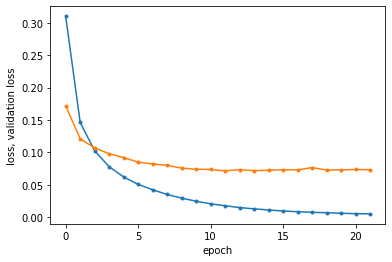

In [27]:
plt.plot(history.epoch, history.history['loss'],'.-')
plt.plot(history.epoch, history.history['val_loss'],'.-')
plt.xlabel('epoch')
plt.ylabel('loss, validation loss')

Text(0, 0.5, 'accuracy, validation accuracy')

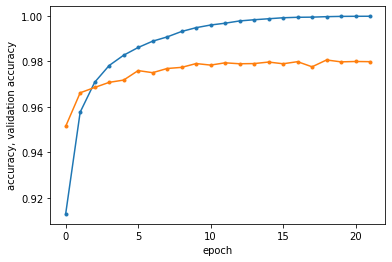

In [28]:
plt.plot(history.epoch, history.history['accuracy'],'.-')
plt.plot(history.epoch, history.history['val_accuracy'],'.-')
#plt.ylim(0.8,1)
plt.xlabel('epoch')
plt.ylabel('accuracy, validation accuracy')

### Q: What if we'd like to change the number of hidden layers?

Unfortunately, there is no built-in module to do this. You will have to run a separate hyperparameter optimization script for DNNs having different number of layers. My suggestion would be to start with the simplest configuration (i.e., one hidden layer) and increase the number of hidden layers while monitoring the performance.

### TODO: Can you optimize hyperparameters of DNNs having two hidden layers? Did the performance improve?

In [29]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu')) ## added a hidden layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    ## if you wanted to vary number of neurons, you'd do this. But this isn't really good so don't
  #  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  #  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  #  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  #  model.add(keras.layers.Dense(units=hp_units2, activation='relu')) ## added a hidden layer
  #  model.add(keras.layers.Dense(10, activation='softmax'))

    ## changing the optimizer, so we want to change the optimizer and learning rate
    adam = keras.optimizers.Adam(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1])) ## choose adam, inside adam change learning rate
    rmsprop = keras.optimizers.RMSprop(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1])) ## same^ 
    sgd = keras.optimizers.SGD(lr=hp.Choice('learning_rate', values=[1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1]))
   
    choiceval = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']) ## now choose b/t the three above
    
    if choiceval == 'adam': ## if adam is chosen, use optimizer adam
        optim = adam
    elif choiceval == 'rmsprop': ## same ^
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(optimizer=optim,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [32]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     seed=0,
                     hyperband_iterations=1,
                     project_name='hptest3')

In [ ]:
tuner.search(X_train, y_train, validation_split=0.2)

Trial 17 Complete [00h 00m 32s]
val_accuracy: 0.9769166707992554

Best val_accuracy So Far: 0.9769166707992554
Total elapsed time: 00h 03m 12s

Search: Running Trial #18

Hyperparameter    |Value             |Best Value So Far 
units             |96                |352               
learning_rate     |0.01              |0.001             
optimizer         |adam              |adam              
tuner/epochs      |10                |10                
tuner/initial_e...|4                 |4                 
tuner/bracket     |2                 |2                 
tuner/round       |2                 |2                 
tuner/trial_id    |3d4bd8564d2f5af...|7038267c67a6d0e...

Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2935 - accuracy: 0.9140 - val_loss: 0.2086 - val_accuracy: 0.9435
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2039 - accuracy: 0.9443 - val_loss: 0.2091 - val_accuracy: 0.9443
Epoch 7/10
1500/1500 [=====